1) Кластеризация Affinity Propagation
2) Предсказание результатов кластеризации через XGBoost и поиск драйверов отнесения региона к тому или иному кластеру
3) Визуализации
4) Визуализация и сокращение размерности -- TSNE

In [1]:
import numpy as np
import pandas as pd
import xgboost
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn import metrics, preprocessing
from sklearn.cluster import AffinityPropagation
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

"""Reading Data and Preparing it"""
dataset = pd.read_csv("RegionalPanelData.csv")

X = dataset.drop(["Регион", "Год"], axis=1)
features = X.columns.tolist()

X_scaled = StandardScaler().fit_transform(X)
X_normalized = preprocessing.normalize(X_scaled, norm='l2')

"""Affinity Propagation clustering"""

af = AffinityPropagation(preference=-50, damping=0.9, max_iter=1000, random_state=0).fit(X_normalized)

cluster_centers_indices = af.cluster_centers_indices_
n_clusters = len(cluster_centers_indices)
labels = af.labels_

"""Clustering Evalutaion"""

print(f"\n=== CLUSTERING RESULTS ===")
print(f"Number of clusters: {n_clusters}")
print(f"Cluster distribution: {np.bincount(labels + 1)}")

print(
    "Silhouette Coefficient: %0.3f"
    % metrics.silhouette_score(X_normalized, labels, metric="sqeuclidean")
)

print(
    "DB score: %0.3f"
    % metrics.davies_bouldin_score(X_normalized, labels)
)

print(
    "Calinski-Harabasz Score score: %0.3f"
    % metrics.calinski_harabasz_score(X_normalized, labels)

)

"""XGBoost explaining the clustering results"""

Y = pd.DataFrame(labels)
X = dataset.drop(columns=["Регион", "Год"])

model = xgboost.XGBClassifier().fit(X, Y)

feature_importance = pd.DataFrame({
        'feature': features,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=True)


=== CLUSTERING RESULTS ===
Number of clusters: 6
Cluster distribution: [  0 195 249 226  91 167 130]
Silhouette Coefficient: 0.332
DB score: 1.537
Calinski-Harabasz Score score: 208.445


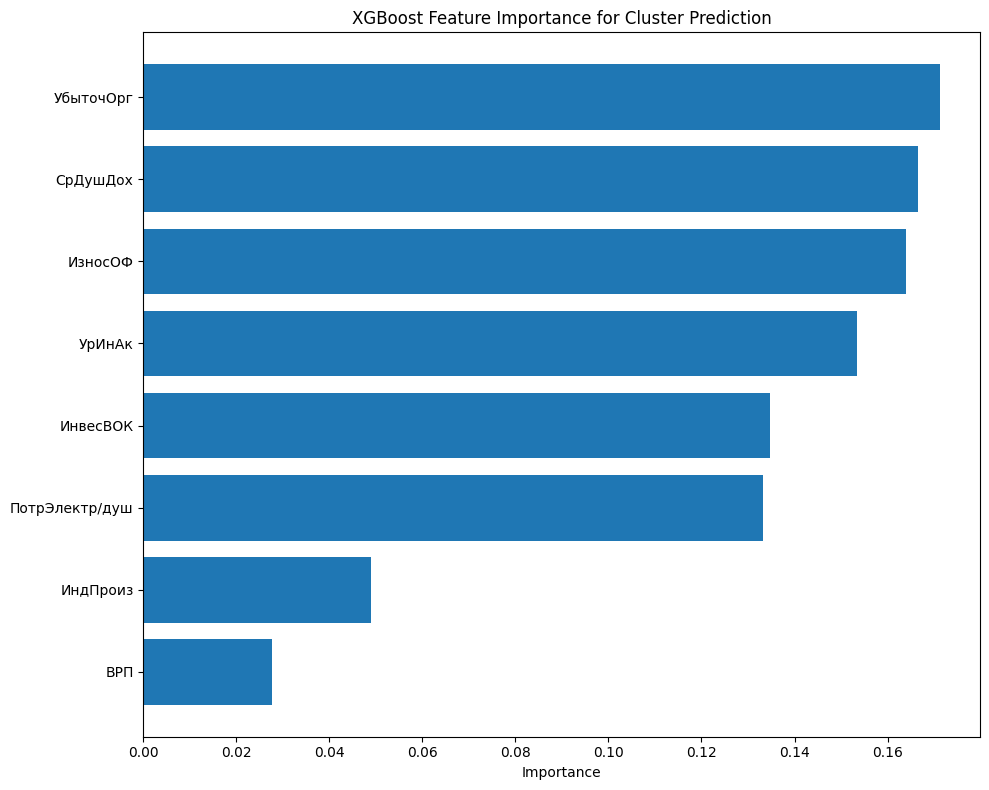

<Figure size 1200x600 with 0 Axes>

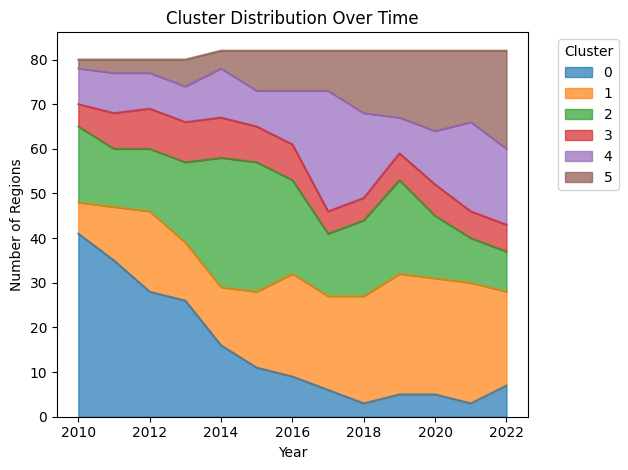

Text(0.5, 23.52222222222222, 'Cluster')

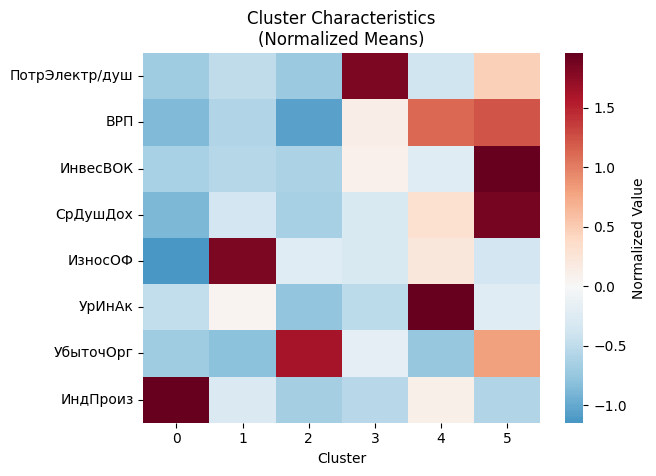

In [2]:
"""Feature Importance"""
plt.figure(figsize=(10, 8))
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.title('XGBoost Feature Importance for Cluster Prediction')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

"""Choronlogical dynamics of cluster composition"""
plt.figure(figsize=(12, 6))
temporal_data = dataset.copy()
temporal_data['Cluster'] = labels
cluster_by_year = temporal_data.groupby(['Год', 'Cluster']).size().unstack(fill_value=0)
cluster_by_year.plot(kind='area', stacked=True, alpha=0.7)
plt.title('Cluster Distribution Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Regions')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

"""Heatmap"""
cluster_data = X.copy()
cluster_data['Cluster'] = labels
# Calculate mean values for each cluster
cluster_means = cluster_data.groupby('Cluster').mean()
# Normalize for better heatmap visualization
cluster_means_normalized = (cluster_means - cluster_means.mean()) / cluster_means.std()
sns.heatmap(cluster_means_normalized.T, cmap='RdBu_r', center=0, 
           cbar_kws={'label': 'Normalized Value'})
plt.title('Cluster Characteristics\n(Normalized Means)')
plt.xlabel('Cluster')

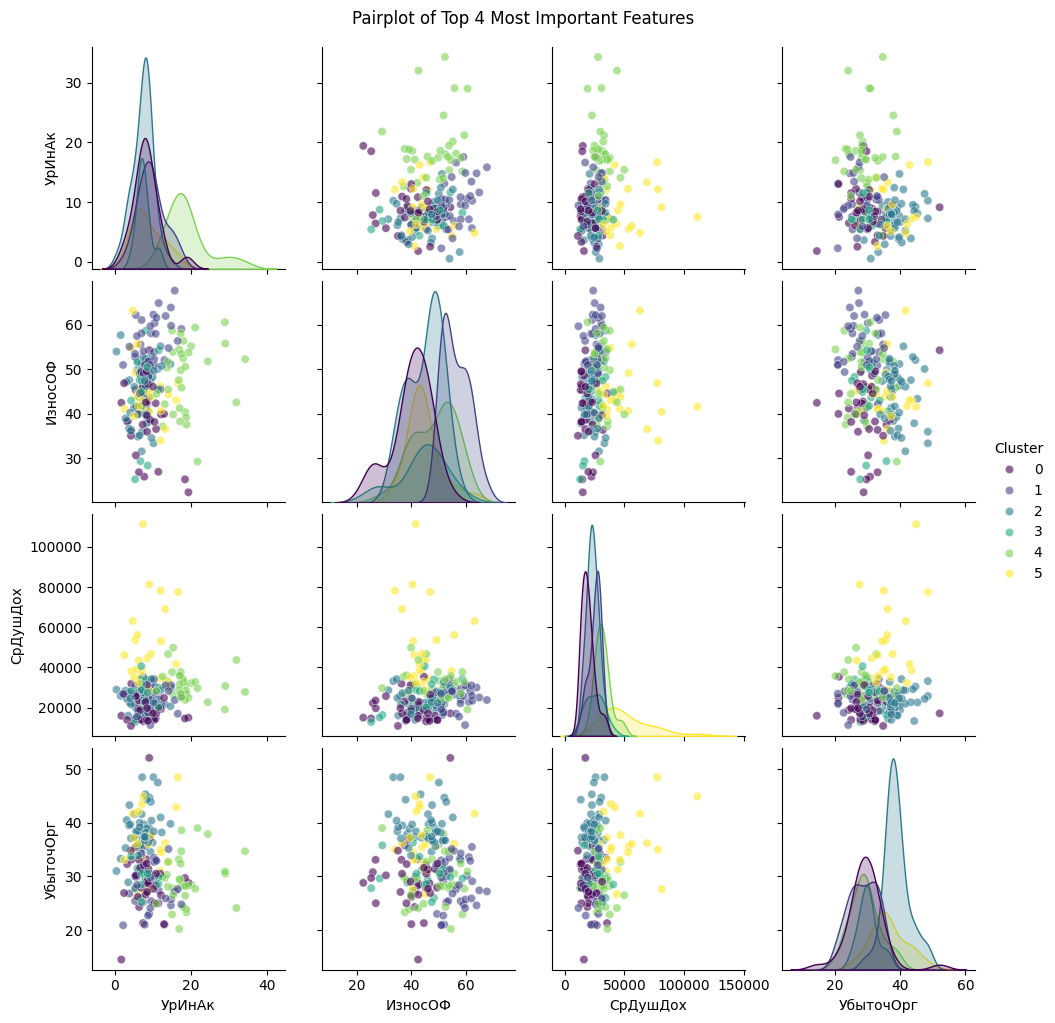

In [3]:
"""Pairplot"""
top_4_features = feature_importance.tail(4)['feature'].tolist()
pairplot_data = X[top_4_features].copy()
pairplot_data['Cluster'] = labels

if len(pairplot_data) > 200:
    pairplot_data = pairplot_data.sample(200, random_state=472)
    
sns.pairplot(pairplot_data, hue='Cluster', palette='viridis', plot_kws={'alpha': 0.6})
plt.suptitle('Pairplot of Top 4 Most Important Features', y=1.02)
plt.show()

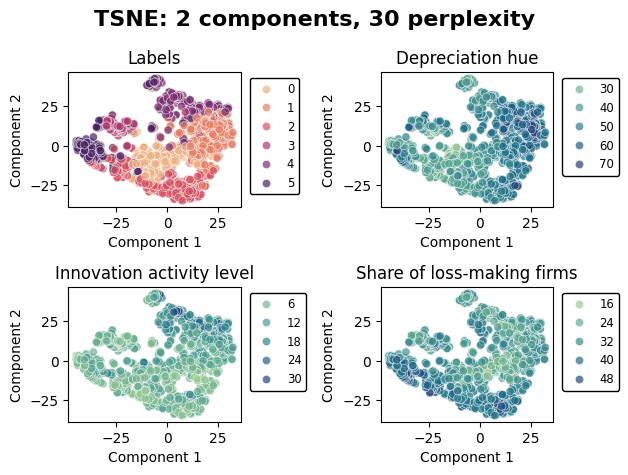

In [4]:
"""TSNE"""
X_embed = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=30).fit_transform(X_normalized)

figure, axis = plt.subplots(2, 2)

sns.scatterplot(
    x=X_embed[:, 0], y=X_embed[:, 1],
    hue=Y.squeeze(),
    palette=sns.color_palette("flare", as_cmap=True),
    legend="brief",
    alpha=0.7,
    ax=axis[0, 0])

sns.scatterplot(
    x=X_embed[:, 0], y=X_embed[:, 1],
    hue=X["ИзносОФ"],
    palette=sns.color_palette("crest", as_cmap=True),
    legend="brief",
    alpha=0.7,
    ax=axis[0, 1])

sns.scatterplot(
    x=X_embed[:, 0], y=X_embed[:, 1],
    hue=X["УрИнАк"],
    palette=sns.color_palette("crest", as_cmap=True),
    legend="brief",
    alpha=0.7,
    ax=axis[1, 0])

sns.scatterplot(
    x=X_embed[:, 0], y=X_embed[:, 1],
    hue=X["УбыточОрг"],
    palette=sns.color_palette("crest", as_cmap=True),
    legend="brief",
    alpha=0.7,
    ax=axis[1, 1])

for ax in axis.flatten():
    ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', frameon=True,
              facecolor='white', framealpha=1, edgecolor='black', fontsize='small')

plt.suptitle('TSNE: 2 components, 30 perplexity', fontsize=16, fontweight='bold')

axis[0,0].set_title("Labels")
axis[0,0].set_xlabel("Component 1")
axis[0,0].set_ylabel("Component 2")

axis[0,1].set_title("Depreciation hue")
axis[0,1].set_xlabel("Component 1")
axis[0,1].set_ylabel("Component 2")

axis[1,0].set_title("Innovation activity level")
axis[1,0].set_xlabel("Component 1")
axis[1,0].set_ylabel("Component 2")

axis[1,1].set_title("Share of loss-making firms")
axis[1,1].set_xlabel("Component 1")
axis[1,1].set_ylabel("Component 2")

plt.tight_layout()